### Imports

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns

# for hierarchical clusterization
from scipy.cluster.hierarchy import dendrogram, linkage  
from scipy.spatial.distance import  pdist
from matplotlib import pyplot as plt
from sklearn.preprocessing import MinMaxScaler

# system
from datetime import datetime
import os
sns.set()

In [256]:
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
from sklearn.metrics import silhouette_score
from sklearn.model_selection import GridSearchCV

## Functions for preprocessing

the resulting functions for fast preprocessing - the result of this notebook

In [11]:
data = pd.read_csv("data//raai_school_2024.csv", sep = ";")
data["payment_period"] = pd.to_datetime(data["payment_period"])
anomaly_column = pd.read_csv("data//anomaly_column.csv", sep = ";")
data["is_anomaly"] = anomaly_column["is_anomaly"].fillna(1.)
data['user_id'] = data['house_tkn'].astype(str) + '_' + data['flat_tkn'].astype(str)

## Analysis part

In [258]:
data = pd.read_csv("data//raai_school_2024.csv", sep = ";")
data["payment_period"] = pd.to_datetime(data["payment_period"])
data['user_id'] = data['house_tkn'].astype(str) + '_' + data['flat_tkn'].astype(str)
data.head()

,house_tkn,flat_tkn,payment_period,income,debt,raised,volume_cold,volume_hot,volume_electr,user_id
0,2,23170,2023-01-01,2073.48,2046.36,0.00,5.33,6.91416,199.50,2_23170
1,2,23170,2023-03-01,1525.44,2484.21,2404.08,5.19,4.22532,186.00,2_23170
2,2,23170,2023-04-01,1762.49,2337.36,1672.29,5.00,4.82284,227.50,2_23170
3,2,23170,2023-05-01,1868.41,0.00,4099.85,5.08,5.13227,242.03,2_23170
4,2,23170,2023-07-01,2682.54,1933.29,0.00,8.64,6.91416,362.00,2_23170


In [259]:
data.shape

(3206079, 10)

## Descriptional analysis

На что надо обратить внимание

1. Как можно заметить внизу в данных есть заметные выбросы. Но они легко отбрасываются при помощи 5% перцентиля.
2. В данных $volume$ есть пробелы заполенные NaN. Их не получится просто отбросить учитывая что они занимают почти половину строк. Факт: было подтверждено что у многих вместо горячей воды стоят какие-то собственные приспособление так что за горячую воду они не платят. Осталось догадаться, понять есть ли люди без элекричества или дом просто пустует.  

In [ ]:
data.describe()

In [ ]:
features = ['income', 'debt', 'raised']
fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(8, 6))

for i, feature in enumerate(features):
    lower_bound = np.percentile(data[feature].dropna(), 5)
    upper_bound = np.percentile(data[feature].dropna(), 95)
    filtered_data = data[feature][(data[feature] >= lower_bound) & (data[feature] <= upper_bound)].dropna()
    axes[i].hist(filtered_data, bins=20, alpha=0.5)  # Apply log transformation
    axes[i].set_xlabel(feature)
    axes[i].set_ylabel('Frequency')

plt.tight_layout()
plt.show()

### Searching anomalies with scatter plots and basic deduction

In [ ]:
sns.scatterplot(x = 'volume_cold', y = 'volume_hot', data = data)
plt.title('Points of cold, hot volume')

In [ ]:
print(f"Meanwhile median for cold water: {data.volume_cold.median()}, hot water: {data.volume_hot.median()}")

### Мини исследование отсутствующих значений.

In [ ]:
data['volume_cold_na'] = data.volume_cold.isna()
data['volume_hot_na'] = data.volume_hot.isna()
data['volume_electr_na'] = data.volume_electr.isna()

counts = pd.DataFrame({
    'volume_cold_na': [data['volume_cold_na'].sum(), 
                       data[['volume_cold_na', 'volume_hot_na']].all(axis=1).sum(),
                       data[
                           ['volume_cold_na', 'volume_electr_na']].all(axis=1).sum()],
    'volume_hot_na': [data[
                           ['volume_cold_na', 'volume_hot_na']].all(axis=1).sum(),
                       data['volume_hot_na'].sum(),
                       data[['volume_hot_na', 'volume_electr_na']].all(axis=1).sum()],
    'volume_electr_na': [data[['volume_cold_na', 'volume_electr_na']].all(axis=1).sum(),
                       data[['volume_hot_na', 'volume_electr_na']].all(axis=1).sum(),
                       data['volume_electr_na'].sum()]
}, index=['volume_cold_na', 'volume_hot_na', 'volume_electr_na'])

plt.figure(figsize=(8, 6))
sns.heatmap(counts, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.xlabel('Missing Values')
plt.ylabel('Missing Values')
plt.title('Intersection of Missing Values in School Data')

plt.show()

In [ ]:
cold_no_hot_water = data['volume_hot_na'] & (1 - data['volume_cold_na'])
cold_and_hot_water = (1 - data['volume_hot_na']) & (1 - data['volume_cold_na'])
no_cold_no_hot_water = data['volume_hot_na'] & data['volume_cold_na']

features = ['income', 'raised', 'volume_cold', 'volume_electr']

fig, axes = plt.subplots(nrows=4, ncols=1, figsize=(8, 20))

for i, feature in enumerate(features):
    lower_bound = np.percentile(data[feature].dropna(), 5)
    upper_bound = np.percentile(data[feature].dropna(), 95)
    filtered_indices = (data[feature] >= lower_bound) & (data[feature] <= upper_bound)

    filtered_cold_no_hot_water = data[feature][cold_no_hot_water & filtered_indices].dropna()
    filtered_cold_and_hot_water = data[feature][cold_and_hot_water & filtered_indices].dropna()
    filtered_no_cold_no_hot_water = data[feature][no_cold_no_hot_water & filtered_indices].dropna()

    axes[i].hist(np.log(filtered_cold_no_hot_water + 1), alpha=0.5, label='Cold Only', bins=20)
    axes[i].hist(np.log(filtered_cold_and_hot_water + 1), alpha=0.5, label='Cold & Hot', bins=20)
    axes[i].hist(np.log(filtered_no_cold_no_hot_water + 1), alpha=0.5, label='No Cold & No Hot', bins=20)
    
    axes[i].set_xlabel("Log " + feature)
    axes[i].set_ylabel('Frequency')
    axes[i].legend()

plt.title("Difference between flats with or without hot water")
plt.tight_layout()
plt.show()

### Исследование по электричеству

Выводы:
- если электричества нет то совершенно не факт что нет показателей воды.
- в 37% случаев есть показания воды хотя нет электрчества
- если есть показания горячей воды то почти наверное есть холодная вода, хотя один процент несколько подозрителен. Были замечены некоторые дома с подозрительным количеством жителей у которых только горячая вода, хотя большая часть все же распределена по небольшим группам
- внизу я еще пыталась понять как выглядят те пользователи без холодной воды и стало понятно что большая часть - индивидуальные случаи максимум с парой показаний, вероятно у них просто что-то сломалось. С другой стороны есть дома с массовым отсутствием воды (типа 50 жителей без холодной воды судя по всему по 9 месяцев). Странный дом, а именно 144191 имеет аж 124 жителя которые живут без холодной воды до 7 месяцев

In [ ]:
print("Percent of houses with hot & cold water:", sum((1 - data['volume_hot_na']) & (1 - data['volume_cold_na'])) / data.shape[0] * 100)
print("Percent of houses with only cold water:", sum(data['volume_hot_na'] & (1 - data['volume_cold_na'])) / data.shape[0] * 100)
print("Percent of houses with only hot water:", sum(data['volume_cold_na'] & (1 - data['volume_hot_na'])) / data.shape[0] * 100)
print("Percent of houses with no hot & no cold water:", sum((1 - data['volume_hot_na']) & (1 - data['volume_cold_na'])) / data.shape[0] * 100)

print("-----------------------------------------------------------------------------------------------------")

print("Percent of houses with no electricity yet cold water:", sum(data['volume_electr_na'] & (1 - data['volume_cold_na'])) / data.shape[0] * 100)
print("Percent of houses with no electricity yet hot water:", sum(data['volume_electr_na'] & (1 - data['volume_hot_na'])) / data.shape[0] * 100)
print("Percent of houses with no electricity yet cold & hot water:", sum(data['volume_electr_na'] & (1 - data['volume_cold_na']) & (1 - data['volume_hot_na'])) / data.shape[0] * 100)

### Выделение пользователей у которых нет горячей воды / отключение выборочное

In [ ]:
data['month_of_admission'] = data['payment_period'].map(lambda dt: dt.strftime('%Y-%m'))
data.groupby('month_of_admission')["volume_hot_na"].sum().to_frame("count").reset_index().plot(kind='bar', x='month_of_admission', y='count', title = "Distribution of no-hot-water entries between months")

In [ ]:
print(f"Average number months of payment: {grouped.size().mean()}")

In [ ]:
data = data.sort_values('payment_period')
grouped = data.groupby('user_id')

def check_missing_months(user_data):
    # Sort by 'month_of_admission'
    user_data = user_data.sort_values('payment_period')
    # user_data['payment_period'] = pd.to_datetime(user_data['payment_period'])
    
    first_month = user_data['payment_period'].min()
    last_month = user_data['payment_period'].max()
    expected_months = pd.date_range(first_month, last_month, freq='MS', inclusive="both")

    # Find missing months
    missing_months = expected_months[~expected_months.isin(user_data['payment_period'])]
    exclude_months = pd.to_datetime(["2023-10-01", "2023-12-01"])
    missing_months = missing_months[~missing_months.isin(exclude_months)]
    return missing_months

number_skips = 0
for user_id, user_data in grouped:
    i += 1
    missing_months = check_missing_months(user_data)
    if missing_months is not None and not missing_months.empty:
        if number_skips < 100:
            print(f"User {user_id} has missing months: {missing_months.strftime('%Y-%m').tolist()}")
        number_skips += 1
print(number_skips)

In [ ]:
grouped[grouped["user_id"] == "100005_263170"]

In [ ]:
grouped = data.groupby('user_id')

def check_missing_months(user_data):
    # Sort by 'month_of_admission'
    user_data = user_data.sort_values('month_of_admission')
    user_data['month_of_admission'] = pd.to_datetime(user_data['month_of_admission'])
    
    first_month = user_data['month_of_admission'].min()
    last_month = user_data['month_of_admission'].max()
    expected_months = pd.date_range(first_month, last_month, freq='M')

    # Find missing months
    missing_months = expected_months[~expected_months.isin(user_data['month_of_admission'])]
    return missing_months

for user_id, user_data in grouped:
    missing_months = check_missing_months(user_data)
    if not missing_months.empty:
        print(f"User {user_id} has missing months: {missing_months.strftime('%Y-%m').tolist()}")

In [ ]:
# Plan how to devide users into groups with 

grouped = data.groupby('user_id')
users_with_no grouped["volume_hot_na"].sum().astype(int).reset_index(name="count")

### Отдельное исследование людей с горячей водой но не холодной :/

In [ ]:
weird_guys = data[data['volume_cold_na'] & (1 - data['volume_hot_na'])] # hot & no cold
weird_guys.shape

In [ ]:
print(f"Number of houses with citizens who got only hot water yet no cold {len(weird_guys.house_tkn.unique())}, average entries per house {weird_guys.shape[0] / len(weird_guys.house_tkn.unique())}\nMeanwhile there're average {data.shape[0] / len(data.house_tkn.unique())} entries per house in all data")

print(f"Number of unique citizens who got only hot water yet no cold {len(weird_guys.user_id.unique())}, average entries per user {weird_guys.shape[0] / len(weird_guys.user_id.unique())}\nMeanwhile there're average {data.shape[0] / len(data.user_id.unique())} entries per user in all data")

In [ ]:
plt.hist(np.log(weird_guys.house_tkn.value_counts()), bins = 10)
plt.title("Logged number entries with hot & no cold water per house")

plt.show()

In [ ]:
weird_guys.groupby("user_id").size().nlargest(10)

In [ ]:
weird_guys.groupby("house_tkn").size().nlargest(5)

In [ ]:
print("Cursed house:")
print("Number cursed flats in the cursed house:", weird_guys[weird_guys["house_tkn"] == 144191]["user_id"].nunique())
print("Number cursed entries for dwellers of the cursed house:", weird_guys[weird_guys["house_tkn"] == 144191]["user_id"].value_counts().mean())
print("Number super cursed dwellers of the house:", sum(weird_guys[weird_guys["house_tkn"] == 144191]["user_id"].value_counts() == 7))

In [ ]:
plt.hist(weird_guys.groupby("house_tkn")["user_id"].nunique(), bins = 20)
plt.title("Number users with hot & no cold water per house")
plt.show()

In [ ]:
weird_guys.groupby("house_tkn")["user_id"].value_counts()

In [ ]:
weird_guys.house_tkn.value_counts()

## Распределение по месяцам

<Axes: xlabel='month_of_admission'>

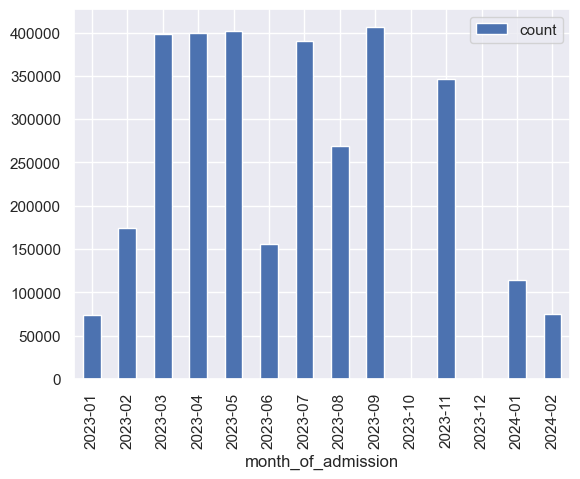

In [58]:
data['month_of_admission'] = data['payment_period'].map(lambda dt: dt.strftime('%Y-%m'))
data.groupby('month_of_admission').size().to_frame("count").reset_index().plot(kind='bar', x='month_of_admission', y='count')

## Preprocessing
- удаление двух месяцев у которых мало записей
- one-hot encoding месяцев
- выделение конкретных **домов** с аномально маленькими/большими значениями по каждому из столбцов
- EIF, возможно другие методы если он окажется неадекватным

-> Результатом является data_filtered

In [ ]:
# Deleting negative numbers from volumes
ensure_positive_features = ['income', 'raised', 'volume_cold', 'volume_hot', 'volume_electr']
for feature in ensure_positive_features:
    if sum(data[feature] < 0) != 0:
        print(f"Feature {feature} has unexpected negative values: {sum(data[feature] < 0)}")

### удаление двух месяцев у которых мало записей

In [114]:
data_filtered = data[(data["month_of_admission"] != 10) & (data["month_of_admission"] != 12)]

### one-hot encoding месяцев

In [ ]:
# NATASHA's code here

### выделение конкретных **домов** с аномально маленькими/большими значениями по каждому из столбцов
- Наташа
- ОБЯЗАТЕЛЬНО сделай чистку месяцев до этого.
Удобно просто строить перцептили с pandas - посмотри как я выше это делала

- Идеи: чуваки которые не отправляют данные и не платят (у них капает за электроэнергию). Чуваки которые тратят много ровно по одному параметру. Чуваки которые тратят много по всем параметрам (а-ля многодетная семья) 

In [ ]:
# NATASHA's code here

### Artificial cutoff of the anomaly values
- for each volume take a percentile, but do not exclude NaN or 0

In [115]:
def clip_by_percentile(data, percentile = 0.95):
    numeric_features = ['income', 'debt', 'raised',
           'volume_cold', 'volume_hot', 'volume_electr']

    for feature in numeric_features:
        threshold = data[feature].quantile(percentile)
        data_filtered[feature] = data[feature].clip(upper=threshold)

    for feature in ['income', 'debt', 'raised']:
        threshold = data[feature].quantile(1-percentile)
        data_filtered[feature] = data[feature].clip(lower=min(0, threshold))
    
    return data
        
data_filtered = clip_by_percentile(data_filtered)

### Filling NaN values
1. Нахождение людей у которых просто нет горячей воды, заполнение таких значениями -1.
2. Отрицательные значения volume временно заполняем 0
3. Всех остальных имеет смысл заполнть медианой так как мы работаем на уровне записей

#### Filling hot water

In [62]:
# Issue is - we have various cases for hot water. It might be planned turnoff, it might be just a missed value
# it might be that user doesn't have hot water (and therefore doesn't pay).
def fill_nan_hot_water(
    data, # the table that has the nan values
    fill_value_seasonal_turnoff = 0, # value to fill users who had a planned turnoff
    fill_value_no_hot = 0, # value to fill the users who have no hot water with, naturally 0
    fill_value_forgetful_users = 0, # value to fill users who just forgot to send hot water
    add_column_seasonal = True, # whether to add column that there was a planned turnoff
    add_column_no_hot = True,
    add_columns_is_na = False
):
    data["volume_hot_na"] = data["volume_hot"].isna()
    
    # Filling all those who have planned turned off water
    months = data['payment_period'].map(lambda dt: dt.month)
    is_summer_month = (months == 5) | (months == 6) | (months == 7) 
    del months
 
    houses_with_hot_water = data.groupby("house_tkn")["volume_hot_na"].agg(lambda x: not x.any())
    houses_with_no_hot_water_in_summer = data[is_summer_month].groupby("house_tkn")["volume_hot_na"].agg(lambda x: x.all())
    houses_with_seasonal_hot_water = houses_with_hot_water[houses_with_hot_water].index.intersection(
        houses_with_no_hot_water_in_summer[houses_with_no_hot_water_in_summer].index
    )
    del houses_with_hot_water
    del houses_with_no_hot_water_in_summer
    
    data_with_planned_turnoff = data[data["house_tkn"].isin(house_tkns_with_planned[house_tkns_with_planned].index)]
    data_with_planned_turnoff.loc[:, "volume_hot"].fillna(fill_value_seasonal_turnoff, inplace = True)

    data_updated = pd.concat([data_with_planned_turnoff, data[~data["house_tkn"].isin(data_with_planned_turnoff["house_tkn"])]])
    
    if add_column_seasonal:
        data_updated["seasonal_turnoff"] = False
        data_updated.loc[data_updated["house_tkn"].isin(data_with_planned_turnoff["house_tkn"]), "seasonal_turnoff"] = True
    del data_with_planned_turnoff
    
    # Filling all those who have no hot water
    user_ids_who_have_no_hot = data_updated.groupby("user_id")["volume_hot_na"].agg(lambda x: x.all())
    users_with_no_hot = data_updated[data_updated["user_id"].isin(user_ids_who_have_no_hot[user_ids_who_have_no_hot].index)]
    users_with_no_hot["volume_hot"] = users_with_no_hot["volume_hot"].fillna(fill_value_no_hot)

    data_updated = pd.concat([users_with_no_hot, data_updated[~data["user_id"].isin(users_with_no_hot["user_id"])]])
    
    if add_column_no_hot:
        data_updated["no_hot_water"] = False
        data_updated.loc[data_updated["user_id"].isin(users_with_no_hot["user_id"]), "no_hot_water"] = True
    del users_with_no_hot
    
    # Filling the rest
    if add_columns_is_na:
        data_updated["missed_hot_water"] = data_updated["volume_hot"].isna()
    data_updated["volume_hot"] = data_updated["volume_hot"].fillna(fill_value_forgetful_users)
    
    data_updated.drop(columns = ["volume_hot_na"], inplace = True)
    return data_updated

In [52]:
%%time
# Example

data_updated = fill_nan_hot_water(data,
    fill_value_seasonal_turnoff = 0, # value to fill users who had a planned turnoff
    fill_value_no_hot = 0, # value to fill the users who have no hot water with, naturally 0
    fill_value_forgetful_users = 0, # value to fill users who just forgot to send hot water
    add_column_seasonal = True, # whether to add column that there was a planned turnoff
    add_column_no_hot = True,
    add_columns_is_na = True)
data_updated.head()

C:\Users\ulyan\AppData\Local\Temp\ipykernel_21288\2870844300.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_with_planned_turnoff.loc[:, "volume_hot"].fillna(fill_value_seasonal_turnoff, inplace = True)
C:\Users\ulyan\AppData\Local\Temp\ipykernel_21288\2870844300.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  users_with_no_hot["volume_hot"] = users_with_no_hot["volume_hot"].fillna(fill_value_no_hot)
C:\Users\ulyan\AppData\Local\Temp\ipykernel_21288\2870844300.py:42: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data

CPU times: total: 44.3 s
Wall time: 44.8 s


,house_tkn,flat_tkn,payment_period,income,debt,raised,volume_cold,volume_hot,volume_electr,is_anomaly,user_id,seasonal_turnoff,no_hot_water,forgot_hot_water
235,2,24327,2023-01-01,68.13,0.00,26.37,2.36,0.0,NaN,0.0,2_24327,True,True,False
656,2,147760,2023-01-01,0.00,2578.36,1759.71,NaN,0.0,NaN,0.0,2_147760,True,True,False
781,2,208599,2023-01-01,0.00,1253.49,0.00,NaN,0.0,NaN,0.0,2_208599,True,True,False
782,2,208599,2023-03-01,0.00,1253.49,0.00,NaN,0.0,NaN,0.0,2_208599,True,True,False
783,2,208599,2023-04-01,0.00,1253.49,0.00,NaN,0.0,NaN,0.0,2_208599,True,True,False


In [53]:
data_updated[["seasonal_turnoff", "no_hot_water", "missed_hot_water"]].sum(axis = 0)

seasonal_turnoff    1614807
no_hot_water        1637665
forgot_hot_water       1150
dtype: int64

In [55]:
del data_updated

#### Clipping volumes to be >=0 (except hot water)

In [64]:
def clip_volumes(data):
    # Filling negative values with 0 (hot water as I previouslt overlooked didn't have any so we don't wanna clear previous result)
    data["volume_cold"] = data["volume_cold"].clip(lower=0)
    data["volume_electr"] = data["volume_electr"].clip(lower=0)
    return data

### Filling the rest NaN with median & scale

In [65]:
def fill_na_with_median(data):
    # Fill all the left NaNs with median
    from sklearn.impute import SimpleImputer
    imputer = SimpleImputer(strategy='median')
    return imputer.fit_transform(data)

def scale_values(data):
    from sklearn.preprocessing import StandardScaler
    scaler = StandardScaler()
    return scaler.fit_transform(data)

In [67]:
numeric_features = ['income', 'debt', 'raised','volume_cold', 'volume_hot', 'volume_electr']
data_numeric = data_filtered[numeric_features]
assert data_numeric.shape[0] == data_filtered.shape[0]

data_numeric = scale_values(fill_na_with_median(data_numeric))

### EIF for anomaly detection

In [ ]:
# Isolation forest from sklearn
from sklearn.ensemble import IsolationForest

n_trees_values = [1, 5, 10, 50]
max_samples_values = [0.33, 0.5, 0.7] 
contamination = 0.01

scores = []

subset_size = 0.1 
subset_indices = np.random.choice(data_numeric_scaled.shape[0], int(subset_size * data_numeric_scaled.shape[0]), replace=False)
data_subset = data_numeric_scaled[subset_indices]

for n_trees in n_trees_values:
    scores_ = []
    for max_samples in max_samples_values:
        print(f"Processing n_trees = {n_trees}, max_samples = {max_samples}")
        eif = IsolationForest(n_estimators=n_trees, max_samples=max_samples, contamination=contamination)  # Use max_samples
        eif.fit(data_subset)
    
        anomaly_scores = eif.decision_function(data_subset)
        
        score = np.mean(anomaly_scores)
        scores_.append(score)

    scores.append(scores_)

In [ ]:
plt.figure(figsize=(6, 4))
for i, n_trees in enumerate(n_trees_values):
    plt.plot(max_samples_values, scores[i], label=f'n_trees {n_trees}')
plt.xlabel('max_samples')
plt.ylabel('Anomaly score')
plt.title("Sklearn IsolationForest on 10% of data")
plt.legend()
plt.show()

In [ ]:
eif = IsolationForest(n_estimators=10, max_samples=0.7, contamination=0.01)
eif.fit(data_subset)

subset_size = 1000
subset_indices = np.random.choice(data_numeric_scaled.shape[0], subset_size, replace=False)
data_subset_2 = data_numeric_scaled[subset_indices]

original_subset = data_numeric.iloc[subset_indices].copy()
original_subset["anomaly"] = eif.predict(data_subset_2)

In [ ]:
features = ['income', 'debt', 'raised','volume_cold', 'volume_hot', 'volume_electr']

fig, axes = plt.subplots(len(features), len(features), figsize=(30, 28))

for i, feature1 in enumerate(features):
    for j, feature2 in enumerate(features):
        if i == j:
            axes[i, j].axis("off")
        else:
            axes[i, j].scatter(
                original_subset[feature1][original_subset["anomaly"] == 1],
                original_subset[feature2][original_subset["anomaly"] == 1],
                color="blue",
                label="Normal",
            )

            # Scatter plot for anomalies
            axes[i, j].scatter(
                original_subset[feature1][original_subset["anomaly"] == -1],
                original_subset[feature2][original_subset["anomaly"] == -1],
                color="red",
                label="Anomaly",
            )

            axes[i, j].set_xlabel(feature1)
            axes[i, j].set_ylabel(feature2)
            axes[i, j].legend()

plt.tight_layout()
plt.show()

In [ ]:
%%time
eif = IsolationForest(n_estimators=10, max_samples=0.7, contamination=0.01)
anomaly_predictions = eif.fit_predict(data_numeric_scaled)

In [ ]:
anomaly_indices = np.where(anomaly_predictions == -1)[0]

subset_size = 1000
subset_indices = np.random.choice(anomaly_indices, subset_size, replace=True)
original_subset = data_numeric.iloc[subset_indices].copy()
original_subset["anomaly"] = anomaly_predictions[subset_indices]

In [ ]:
normal_indices = np.where(anomaly_predictions == 1)[0]
data_filtered.iloc[normal_indices].describe()

In [ ]:
features = ['income', 'debt', 'raised','volume_cold', 'volume_hot', 'volume_electr']
fig, axes = plt.subplots(len(features), len(features), figsize=(30, 28))

for i, feature1 in enumerate(features):
    for j, feature2 in enumerate(features):
        if i == j:
            axes[i, j].axis("off")
        else:
            axes[i, j].scatter(
                original_subset[feature1][original_subset["anomaly"] == -1],
                original_subset[feature2][original_subset["anomaly"] == -1],
                color="red",
                label="Anomaly",
            )

            axes[i, j].set_xlabel(feature1)
            axes[i, j].set_ylabel(feature2)
            axes[i, j].legend()

plt.tight_layout()
plt.show()

In [ ]:
print(f"IF left {len(normal_indices)} normal, while {len(anomaly_indices)} are anomalies")

In [ ]:
# Saving normal data that was filtered
data_filtered.iloc[normal_indices].to_csv("filtered_unnormalized_data.csv", sep=";", index=False)

# Saving scaled data that has no NaN
replace_columns = ['income', 'debt', 'raised', 'volume_cold', 'volume_hot', 'volume_electr']
data_numeric_df = pd.DataFrame(data_numeric_scaled, columns=replace_columns)
data_filtered[replace_columns] = data_numeric_df
data_filtered.iloc[normal_indices].to_csv("filtered_scaled_data.csv", sep=";", index=False)

# Saving original data with anomaly tag
data_filtered["is_anomaly"] = (anomaly_predictions == -1).astype(int)

merged_data = pd.merge(
    data,
    data_filtered[["house_tkn", "flat_tkn", "payment_period", "is_anomaly"]],
    on=["house_tkn", "flat_tkn", "payment_period"],
    how="left",
)

data["is_anomaly"] = merged_data["is_anomaly"]
data["is_anomaly"] = data["is_anomaly"].fillna(1.0)
data.to_csv("data//original_data_with_anomaly_column.csv", sep=";", index=False)

In [128]:
data["is_anomaly"] = data["is_anomaly"].fillna(1.0)
data.drop(columns = ["month_of_admission", "user_id", "volume_hot_na"]).to_csv("data//original_data_with_anomaly_column.csv", sep=";", index=False)

In [252]:
data_filtered["is_anomaly"] = 1

,house_tkn,flat_tkn,payment_period,income,debt,raised,volume_cold,volume_hot,volume_electr,month_of_admission,volume_cold_na,volume_hot_na,volume_electr_na,user_id
0,2,23170,2023-01-01,0.187621,-0.146264,-0.145109,0.470157,0.791438,-0.039733,1,False,False,False,2_23170
1,34737,208775,2023-01-01,-0.466695,-0.146041,-0.086698,-0.339071,0.322358,-0.039733,1,False,False,True,34737_208775
2,15899,163622,2023-01-01,-0.612532,-0.146041,-0.230077,-0.274897,-0.146721,-0.039733,1,False,False,True,15899_163622
3,94073,454760,2023-01-01,-0.798176,-0.146041,-0.485190,-0.210724,-0.615800,-0.039733,1,False,False,True,94073_454760
4,15899,163621,2023-01-01,-0.892711,-0.146041,-0.740313,-0.403244,-0.615800,-0.039733,1,False,False,True,15899_163621


## Correlation

In [ ]:
plt.figure(figsize=(10, 6))
number_features = ['income', 'debt', 'raised','volume_cold', 'volume_hot', 'volume_electr']
data_with_real_numeric = data[number_features].dropna() 
data_with_real_numeric = (data_with_real_numeric-data_with_real_numeric.mean())/data_with_real_numeric.std()
pearson = data_with_real_numeric.corr(method = 'pearson')
sns.heatmap(pearson, annot = True, fmt = ".3f")
plt.title('Pearson correlation of numerical data')

In [ ]:
plt.figure(figsize=(10, 6))
number_features = ['income', 'debt', 'raised','volume_cold', 'volume_hot', 'volume_electr']
data_with_real_numeric = data[number_features].dropna() 
data_with_real_numeric = (data_with_real_numeric-data_with_real_numeric.mean())/data_with_real_numeric.std()
spearman = data_with_real_numeric.corr(method = 'spearman')
sns.heatmap(spearman, annot = True, fmt = ".3f")
plt.title('Spearman correlation of numerical data')

In [ ]:
plt.figure(figsize=(10, 6))
number_features = ['income', 'debt', 'raised','volume_cold', 'volume_hot', 'volume_electr']
data_with_real_numeric = data[number_features]
data_with_real_numeric = (data_with_real_numeric-data_with_real_numeric.mean())/data_with_real_numeric.std()
spearman = data_with_real_numeric.corr(method = 'spearman')
sns.heatmap(spearman, annot = True, fmt = ".3f")
plt.title('Spearman correlation of numerical data including NaNs')

### Correlation on filtered data

In [4]:
number_features = ['income', 'debt', 'raised','volume_cold', 'volume_hot', 'volume_electr']
data_with_real_numeric = data[number_features].dropna() 
data_with_real_numeric = (data_with_real_numeric-data_with_real_numeric.mean())/data_with_real_numeric.std()

Text(0.5, 1.0, 'Pearson correlation of numerical data')

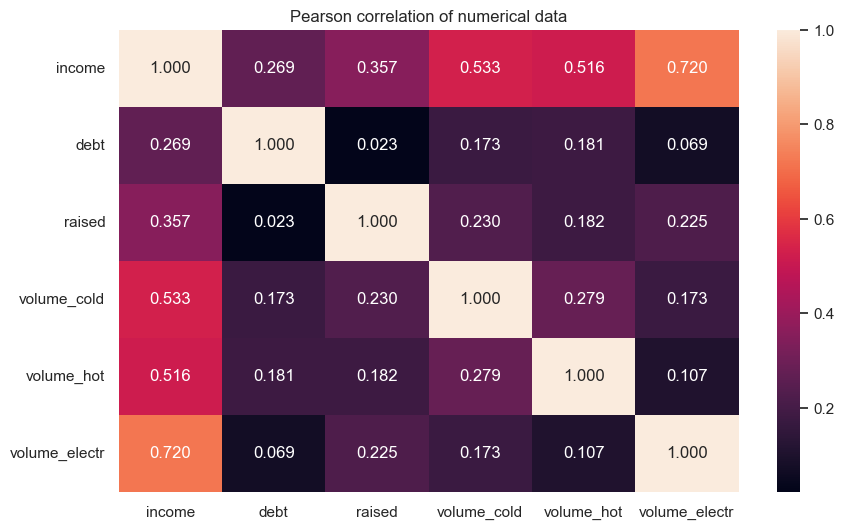

In [7]:
plt.figure(figsize=(10, 6))
pearson = data_with_real_numeric.corr(method = 'pearson')
sns.heatmap(pearson, annot = True, fmt = ".3f")
plt.title('Pearson correlation of numerical data')

Text(0.5, 1.0, 'Spearman correlation of numerical data')

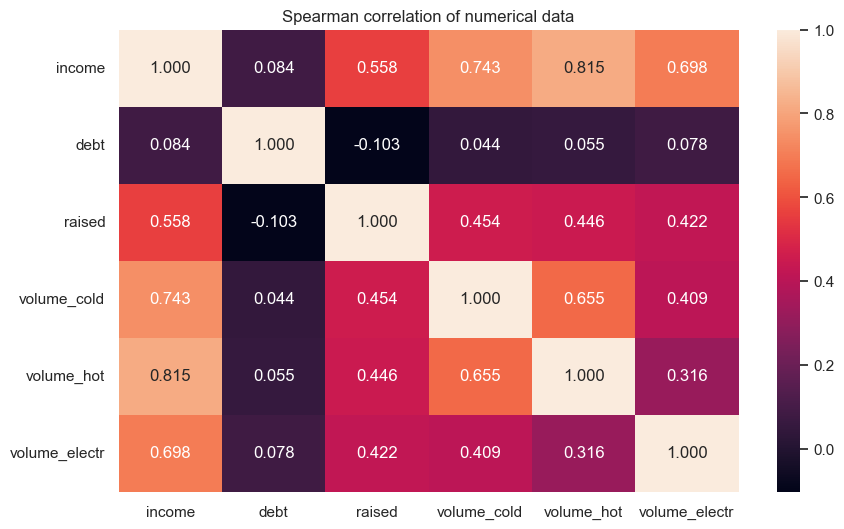

In [8]:
plt.figure(figsize=(10, 6))
number_features = ['income', 'debt', 'raised','volume_cold', 'volume_hot', 'volume_electr']
spearman = data_with_real_numeric.corr(method = 'spearman')
sns.heatmap(spearman, annot = True, fmt = ".3f")
plt.title('Spearman correlation of numerical data')

### But what if we fill NaN with zero or median?

In [73]:
numeric_features = ['income', 'debt', 'raised','volume_cold', 'volume_hot', 'volume_electr']

data_with_real_numeric = pd.DataFrame(data_numeric, columns = numeric_features)
data_with_real_numeric = (data_with_real_numeric-data_with_real_numeric.mean())/data_with_real_numeric.std()

Text(0.5, 1.0, 'Pearson correlation of numerical data')

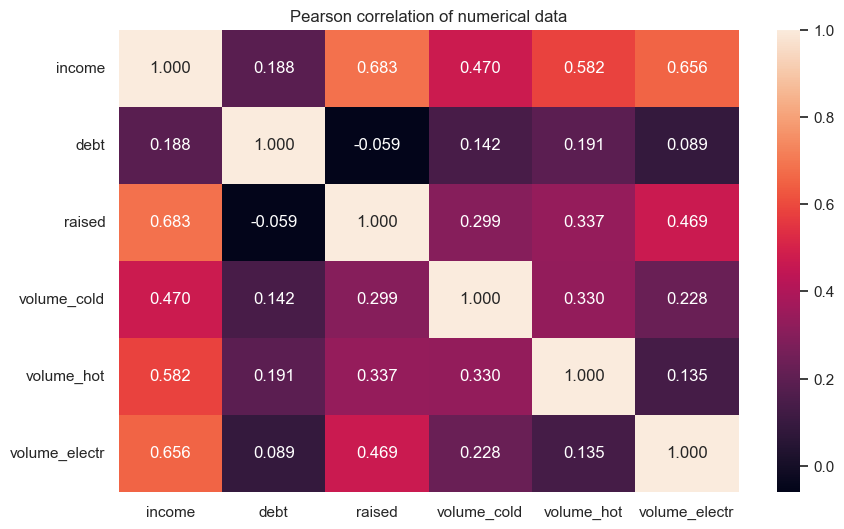

In [74]:
plt.figure(figsize=(10, 6))
pearson = data_with_real_numeric.corr(method = 'pearson')
sns.heatmap(pearson, annot = True, fmt = ".3f")
plt.title('Pearson correlation of numerical data')

Text(0.5, 1.0, 'Spearman correlation of numerical data')

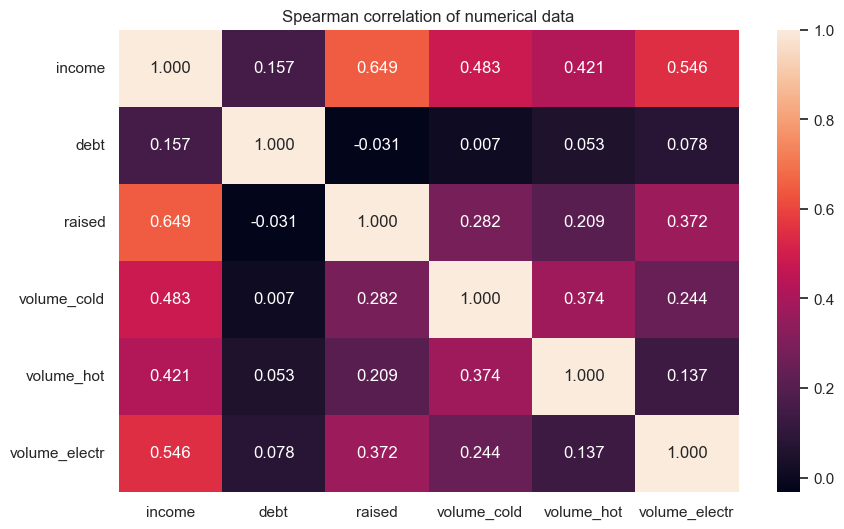

In [75]:
plt.figure(figsize=(10, 6))
number_features = ['income', 'debt', 'raised','volume_cold', 'volume_hot', 'volume_electr']
spearman = data_with_real_numeric.corr(method = 'spearman')
sns.heatmap(spearman, annot = True, fmt = ".3f")
plt.title('Spearman correlation of numerical data')

## Исследование зависимостей между income, dept, raised

In [85]:
money_table = data_filtered[["user_id", "month_of_admission", "income", "debt", "raised"]]
money_table.head()

,user_id,month_of_admission,income,debt,raised
0,2_23170,2023-01,2073.480,2046.36,0.00
1,2_23170,2023-03,1525.440,2484.21,2381.18
2,2_23170,2023-04,1762.490,2337.36,1672.29
3,2_23170,2023-05,1868.410,0.00,2381.18
4,2_23170,2023-07,2375.132,1933.29,0.00


In [86]:
len(money_table["user_id"].unique())

420639

In [90]:
unique_user_ids = money_table["user_id"].unique()[:10000]
money_table = money_table[money_table["user_id"].isin(unique_user_ids)]
money_table = money_table.reset_index(drop=True)

In [107]:
grouped_money_table = money_table.groupby("user_id").apply(lambda x: x.sort_values("month_of_admission"))

grouped_money_table["old_dept"] = grouped_money_table["debt"] - grouped_money_table["debt"].diff()
grouped_money_table["old_income"] = grouped_money_table["income"] - grouped_money_table["income"].diff()
grouped_money_table["old_raised"] = grouped_money_table["raised"] - grouped_money_table["raised"].diff()

In [111]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

grouped_money_table = grouped_money_table.fillna(method='bfill')  # Backfill with the next valid value

features = ['old_dept', 'old_income', 'income', 'raised']
target = 'debt'

X_train, X_test, y_train, y_test = train_test_split(
    grouped_money_table[features], grouped_money_table[target], test_size=0.2, random_state=42
)
model = LinearRegression()
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

mse = mean_squared_error(y_test, y_pred)

print("Model Coefficients:")
print(model.coef_)
print("\nModel Intercept:")
print(model.intercept_)

print(f"Mean Squared Error: {mse:.2f}")

Model Coefficients:
[ 0.72567089 -0.15248612  0.51437202 -0.29142324]

Model Intercept:
43.099573718828935
Mean Squared Error: 994931.37


# Кластеризация данных

- если делать деревом решений то не должно возникать проблемы с NaN значениями
- если делать стандартными методам сначала надо нормализовать и разделить данные на NaN и все остальные, либо выделять тех у кого только холодная вода с целью заставить им эту воду 0, а остальных кокнуть как аномалии вручную. Некоторые стандартные методы: K-Means, DBSCAN

**До начала кластеризации** надо убрать дома и квартиры объединив их в $user\_id$. Дальше надо подумать о том каие признаки можно дабвить в табличку (например максимум, минимум, среднее, отклонение, частота выплат). Также можно пытаться учесть отдельно
1. летний период отключения горячей воды
2. отсутствие горячей воды в доме
3. периоды повышенного потребления воды, например столбца по типу +1 за зимний месяц, -1 за летний или вообще булевые (для K-means очевидно плохая идея)
4. максимальная и минимальная разница между следующим и предыдущим месяцем (имеет смысл по холодной воде чтобы исзбежать разборок с летним отключением воды)
5. среднее, стандартное отклонение ненулевых значений
6. стоимость показателей, при кластеризации имеет смысл более значимо рассматривать **raised**, **income**, **debt**. Учитывая их динамическое изменение имеет смысл их слегка модифицировать для избежания сильной корреляции

In [ ]:
%%time
data_filtered = data[(data["month_of_admission"] != 10) & (data["month_of_admission"] != 12)]
data_filtered = clip_by_percentile(data_filtered)

data_filtered = fill_nan_hot_water(data,
    fill_value_seasonal_turnoff = 0,
    fill_value_no_hot = 0,
    fill_value_forgetful_users = data_filtered["volume_hot"].median(),
    add_column_seasonal = False,
    add_column_no_hot = False,
    add_columns_is_na = False
)

data_filtered = clip_volumes(data_filtered)

columns_with_na = ['volume_cold', 'volume_electr']
data_filtered.loc[:, columns_with_na] = fill_na_with_median(data_filtered[columns_with_na])
data_filtered = data_filtered[data_filtered["is_anomaly"] == 0]

### K-Means / DBSCAN on aggregated partly data

In [137]:
# encode month of admission to be numbers in order (without skips):
months = data_filtered.month_of_admission.unique()
months.sort()

replace_ = {"month_of_admission" : {
    month : i for month, i in zip(months, range(len(months)))
}}
data_filtered = data_filtered.replace(replace_)
data_filtered.head()

,house_tkn,flat_tkn,payment_period,income,debt,raised,volume_cold,volume_hot,volume_electr,is_anomaly,user_id,month_of_admission
235,2,24327,2023-01-01,68.13,0.00,26.37,2.36,0.0,123.0,0.0,2_24327,0
656,2,147760,2023-01-01,0.00,2578.36,1759.71,5.00,0.0,123.0,0.0,2_147760,0
781,2,208599,2023-01-01,0.00,1253.49,0.00,5.00,0.0,123.0,0.0,2_208599,0
782,2,208599,2023-03-01,0.00,1253.49,0.00,5.00,0.0,123.0,0.0,2_208599,2
783,2,208599,2023-04-01,0.00,1253.49,0.00,5.00,0.0,123.0,0.0,2_208599,3


In [160]:
grouped = data_filtered.groupby('user_id')
user_features = grouped.agg({
    'income': ['min', 'max', 'mean', 'std'],
    'debt': ['min', 'max', 'mean', 'std'],
    'raised': ['min', 'max','mean', 'std'],
    'volume_cold': ['min', 'max','mean', 'std'],
    'volume_hot': ['min', 'max','mean', 'std'],
    'volume_electr': ['min', 'max','mean', 'std'],
    'month_of_admission': ['min', 'max', 'nunique'],
})

user_features.columns = ['_'.join(col) for col in user_features.columns]

user_features['payment_delay'] = (user_features['month_of_admission_max'] - user_features['month_of_admission_min'])
user_features['payment_delay'] /= user_features['month_of_admission_nunique']  # Average delay per month

D:\E\Downloads\Anaconda\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


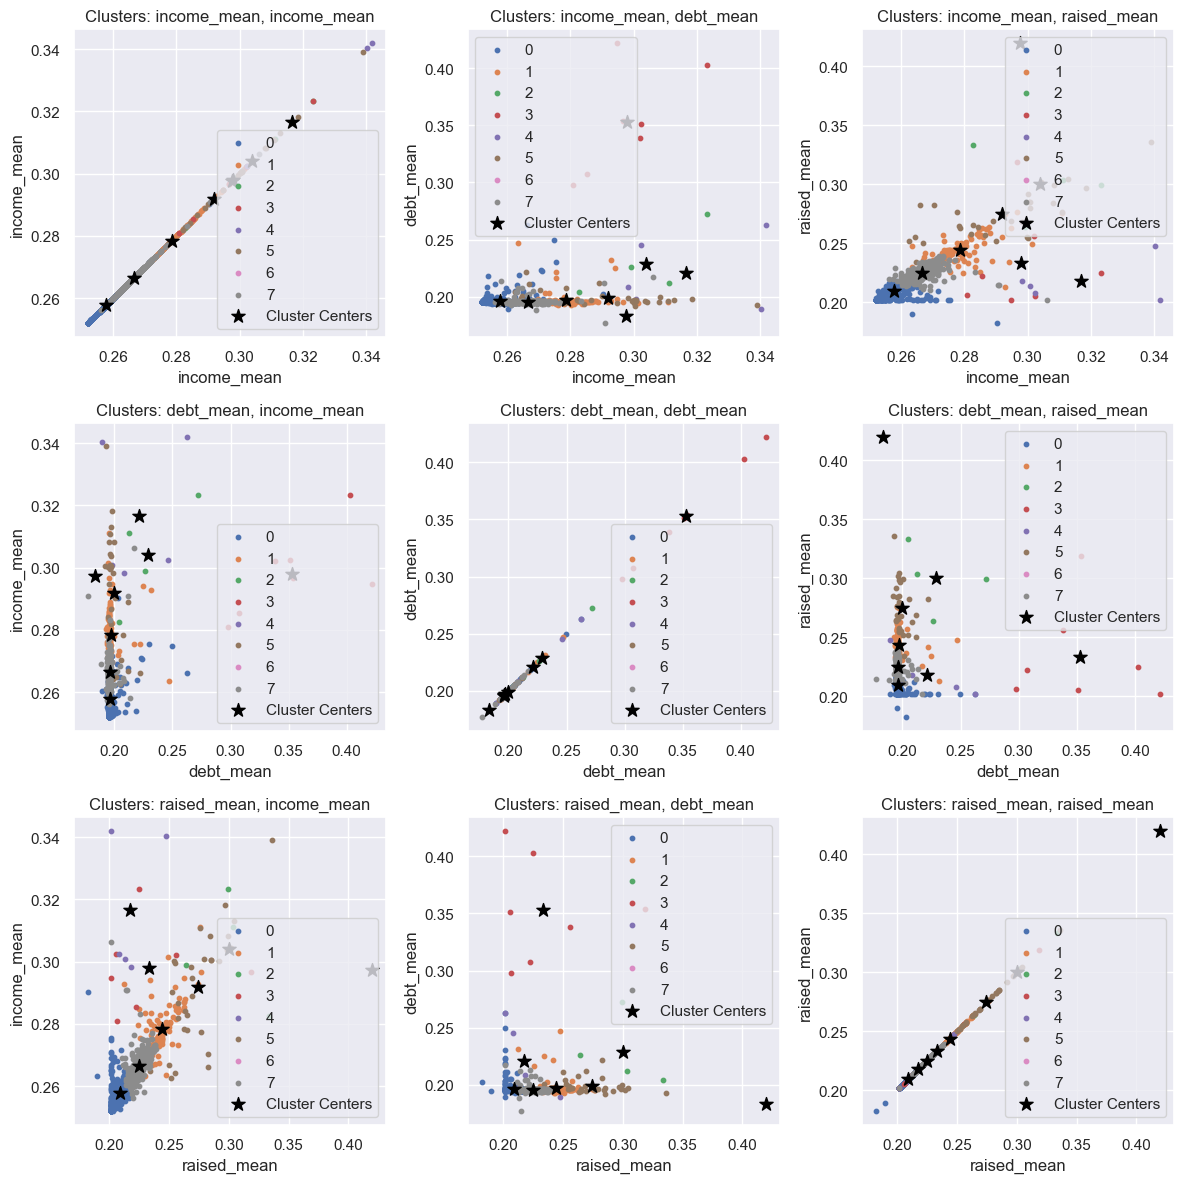

In [161]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler

columns_to_consider = ["income_min", "income_max", "income_mean", "income_std",
                       "debt_min", "debt_max", "debt_mean", "debt_std",
                       "raised_min", "raised_max", "raised_mean", "raised_std"]

user_features = user_features[columns_to_consider].fillna(0)
scaler = MinMaxScaler()
scaled_features = scaler.fit_transform(user_features)

subset_features = scaled_features[:1000]
n_clusters = 8

kmeans = KMeans(n_clusters=n_clusters, random_state=42)
kmeans.fit(subset_features)

labels = kmeans.labels_
cluster_centers = kmeans.cluster_centers_

plot_combinations = [
   2, 6, 10
]

fig, axes = plt.subplots(3, 3, figsize=(12, 12))

for i in range(len(plot_combinations)):
    for j in range(len(plot_combinations)):
        ax = axes[i, j]  # Position in the grid
        x_id = plot_combinations[i]
        y_id = plot_combinations[j]

        # Plot clusters for each combination
        for j in range(n_clusters):  # Adjust for the number of clusters
            cluster_points = subset_features[labels == j]
            ax.scatter(cluster_points[:, x_id], cluster_points[:, y_id], label=f'{j}', s=10)

        # Plot cluster centers
        ax.scatter(cluster_centers[:, x_id], cluster_centers[:, y_id], marker='*', s=100, c='black', label='Cluster Centers')

        # Set axis labels
        ax.set_xlabel(columns_to_consider[x_id])
        ax.set_ylabel(columns_to_consider[y_id])

        # Add a title for each subplot
        ax.set_title(f'Clusters: {columns_to_consider[x_id]}, {columns_to_consider[y_id]}')

        # Add legend
        ax.legend()

# Adjust spacing between subplots
plt.tight_layout()

plt.show()

D:\E\Downloads\Anaconda\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


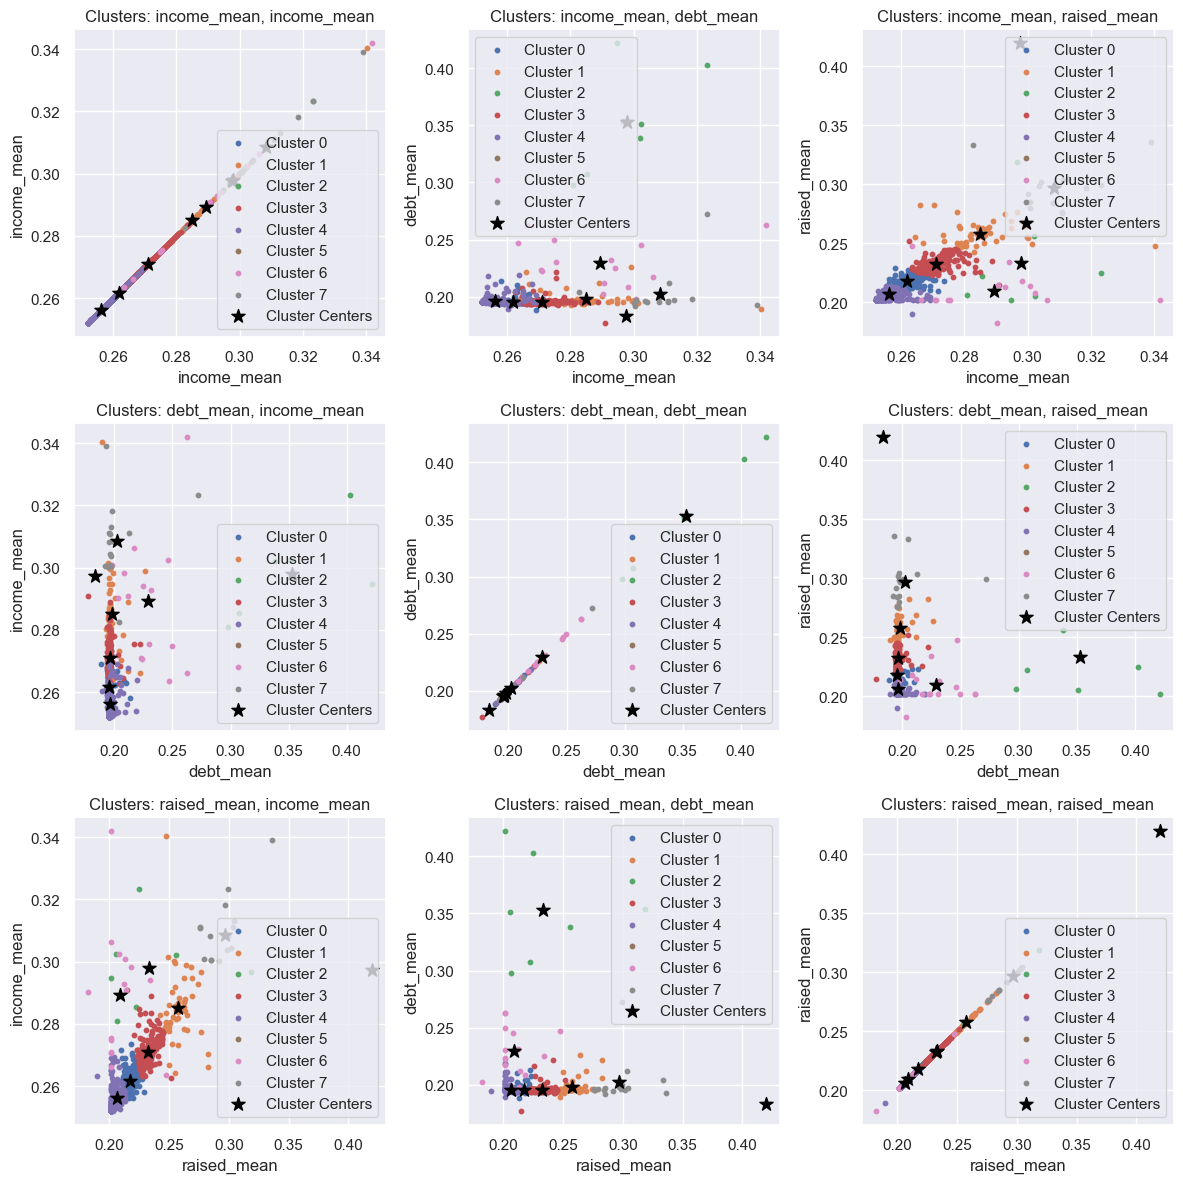

In [156]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler

columns_to_consider = ["income_mean",
                       "debt_mean",
                       "raised_mean",]

user_features = user_features[columns_to_consider].fillna(0)
scaler = MinMaxScaler()
scaled_features = scaler.fit_transform(user_features)

subset_features = scaled_features[:1000]
n_clusters = 8

kmeans = KMeans(n_clusters=n_clusters, random_state=42)
kmeans.fit(subset_features)

labels = kmeans.labels_
cluster_centers = kmeans.cluster_centers_

plot_combinations = [
   0, 1, 2
]

fig, axes = plt.subplots(3, 3, figsize=(12, 12))

for i in range(len(plot_combinations)):
    for j in range(len(plot_combinations)):
        ax = axes[i, j]  # Position in the grid
        x_id = plot_combinations[i]
        y_id = plot_combinations[j]

        # Plot clusters for each combination
        for j in range(n_clusters):  # Adjust for the number of clusters
            cluster_points = subset_features[labels == j]
            ax.scatter(cluster_points[:, x_id], cluster_points[:, y_id], label=f'Cluster {j}', s=10)

        ax.scatter(cluster_centers[:, x_id], cluster_centers[:, y_id], marker='*', s=100, c='black', label='Cluster Centers')

        ax.set_xlabel(columns_to_consider[x_id])
        ax.set_ylabel(columns_to_consider[y_id])

        ax.set_title(f'Clusters: {columns_to_consider[x_id]}, {columns_to_consider[y_id]}')
        ax.legend()

# Adjust spacing between subplots
plt.tight_layout()

plt.show()

D:\E\Downloads\Anaconda\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


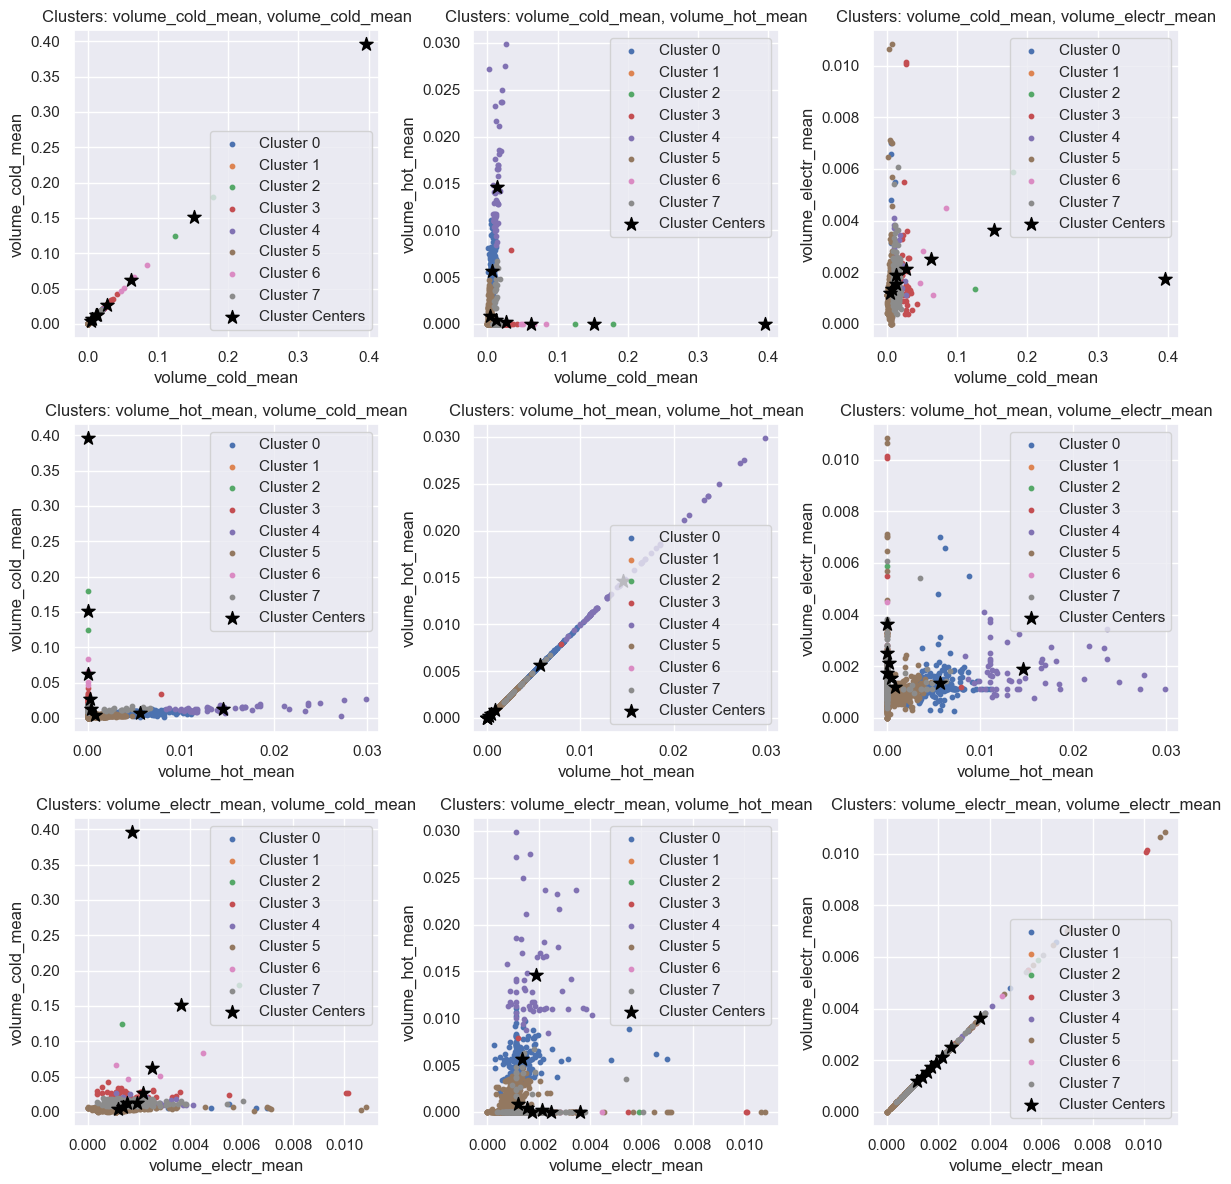

In [159]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler

columns_to_consider = ["volume_cold_mean",
                       "volume_hot_mean",
                       "volume_electr_mean",]

user_features = user_features[columns_to_consider].fillna(0)
scaler = MinMaxScaler()
scaled_features = scaler.fit_transform(user_features)

subset_features = scaled_features[:1000]
n_clusters = 8

kmeans = KMeans(n_clusters=n_clusters, random_state=42)
kmeans.fit(subset_features)

labels = kmeans.labels_
cluster_centers = kmeans.cluster_centers_

plot_combinations = [
   0, 1, 2
]

fig, axes = plt.subplots(3, 3, figsize=(12, 12))

for i in range(len(plot_combinations)):
    for j in range(len(plot_combinations)):
        ax = axes[i, j]  # Position in the grid
        x_id = plot_combinations[i]
        y_id = plot_combinations[j]

        # Plot clusters for each combination
        for j in range(n_clusters):  # Adjust for the number of clusters
            cluster_points = subset_features[labels == j]
            ax.scatter(cluster_points[:, x_id], cluster_points[:, y_id], label=f'Cluster {j}', s=10)

        ax.scatter(cluster_centers[:, x_id], cluster_centers[:, y_id], marker='*', s=100, c='black', label='Cluster Centers')

        ax.set_xlabel(columns_to_consider[x_id])
        ax.set_ylabel(columns_to_consider[y_id])

        ax.set_title(f'Clusters: {columns_to_consider[x_id]}, {columns_to_consider[y_id]}')
        ax.legend()

# Adjust spacing between subplots
plt.tight_layout()

plt.show()

In [ ]:
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

for i in range(n_clusters):
    cluster_points = subset_features[labels == i]
    ax.scatter(cluster_points[:, 0], cluster_points[:, 1], cluster_points[:, 2], label=f'Cluster {i}')

ax.scatter(cluster_centers[:, 0], cluster_centers[:, 1], cluster_centers[:, 2], marker='*', s=200, c='black', label='Cluster Centers')

ax.set_xlabel('Income Mean')
ax.set_ylabel('Debt Mean')
ax.set_zlabel('Raised Mean')

ax.legend()
plt.show()